In [20]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from scipy import ndimage
import glob
import os

In [21]:
def attach_latlon(geo_ds, nav_ds):
    """
    Adds interpolated lat/lon coordinates to a geophysical dataset
    using navigation control points.
    """
    import numpy as np
    from scipy.interpolate import interp1d

    # Control point arrays
    lat_ctl = nav_ds['latitude'].data
    lon_ctl = nav_ds['longitude'].data
    cols = nav_ds['cntl_pt_cols'].data  # pixel_control_points

    # Dimensions
    n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']

    # Allocate arrays for interpolated coordinates
    lat_full = np.empty((n_lines, n_pixels), dtype=np.float32)
    lon_full = np.empty((n_lines, n_pixels), dtype=np.float32)

    for i in range(n_lines):
        f_lat = interp1d(cols, lat_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        f_lon = interp1d(cols, lon_ctl[i, :], bounds_error=False, fill_value="extrapolate")
        lat_full[i, :] = f_lat(np.arange(n_pixels))
        lon_full[i, :] = f_lon(np.arange(n_pixels))

    # Assign to dataset
    geo_ds = geo_ds.assign_coords(
        lat=(('number_of_lines', 'pixels_per_line'), lat_full),
        lon=(('number_of_lines', 'pixels_per_line'), lon_full)
    )

    return geo_ds


In [ ]:
def plot_geophysical_var(ds, var_name, title=None, cmap='viridis'):
    """
    Plots a geophysical variable on a lat/lon map using pcolormesh.
    
    Parameters:
        ds (xarray.Dataset): Dataset with lat/lon coordinates.
        var_name (str): Name of the variable to plot.
        title (str): Optional plot title.
        cmap (str): Colormap to use.
    """
    var = ds[var_name]
    lat = ds['lat']
    lon = ds['lon']
    
    # Apply combined finite mask
    mask = np.isfinite(var) & np.isfinite(lat) & np.isfinite(lon)
    
    # Apply mask and convert to plain numpy arrays
    data = var.where(mask).values
    lat = lat.where(mask).values
    lon = lon.where(mask).values

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.pcolormesh(lon, lat, data, shading='auto', cmap=cmap)
    plt.colorbar(label=var.attrs.get('long_name', var_name))
    plt.xlabel("Longitude")
    plt.ylabel("Latitude")
    plt.title(title or var_name)
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Step 1. Load Your Dataset ---
# Use glob to recursively find all NetCDF files in ./data
nc_files = glob.glob(os.path.join('data', '**', '*.nc'), recursive=True)

print(f"Found {len(nc_files)} NetCDF files.")


Found 41 NetCDF files.


C:\Users\Makai\AppData\Local\Temp\ipykernel_16940\2207796836.py:15: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_lines, n_pixels = geo_ds.dims['number_of_lines'], geo_ds.dims['pixels_per_line']


ValueError: x and y arguments to pcolormesh cannot have non-finite values or be of type numpy.ma.MaskedArray with masked values

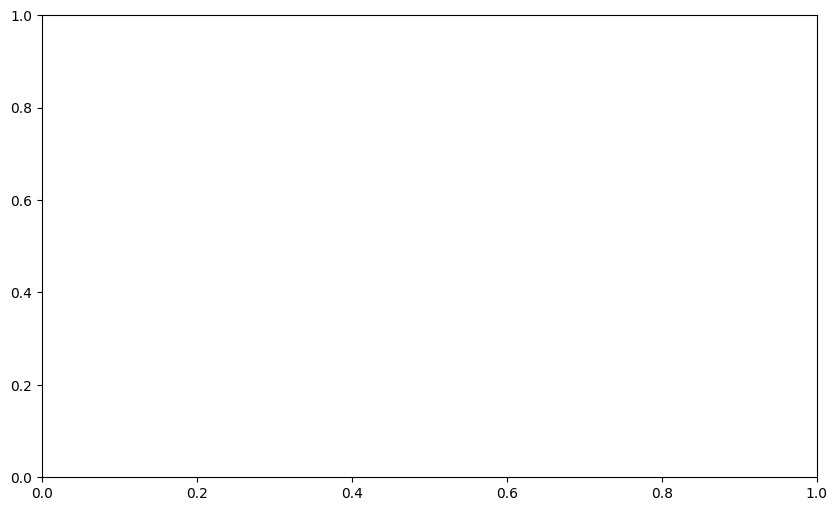

In [26]:
geo_ds = attach_latlon(geo_ds, nav_ds)
plot_geophysical_var(geo_ds, 'chlor_a', title='Chlorophyll-a Concentration')

In [15]:
nav_data = xr.open_dataset(nc_files[0], group='navigation_data')
nav_data

<xarray.Dataset> Size: 22MB
Dimensions:       (number_of_lines: 2030, pixel_control_points: 1354)
Dimensions without coordinates: number_of_lines, pixel_control_points
Data variables:
    longitude     (number_of_lines, pixel_control_points) float32 11MB ...
    latitude      (number_of_lines, pixel_control_points) float32 11MB ...
    cntl_pt_cols  (pixel_control_points) float64 11kB ...
    cntl_pt_rows  (number_of_lines) float64 16kB ...
    tilt          (number_of_lines) float32 8kB ...
Attributes:
    gringpointlongitude:  [-67.345184 -90.39972  -98.16807  -69.44319 ]
    gringpointlatitude:   [27.975039 24.676748 41.873264 45.98114 ]
    gringpointsequence:   [1 2 3 4]

In [16]:
geo_ds = xr.open_dataset(nc_files[0], group='geophysical_data')
nav_ds = xr.open_dataset(nc_files[0], group='navigation_data')

# Assuming 'latitude' and 'longitude' are variables in nav_ds
lat = nav_ds['latitude']
lon = nav_ds['longitude']

# Attach to geophysical dataset as coordinates
geo_ds = geo_ds.assign_coords(lat=(('number_of_lines', 'pixels_per_line'), lat),
                              lon=(('number_of_lines', 'pixels_per_line'), lon))

TypeError: Variable 'lat': Using a DataArray object to construct a variable is ambiguous, please extract the data using the .data property.

In [ ]:
# --- Step 2. Define Time Periods for Comparison ---
# These periods can be adjusted as needed. Here we use two priority periods.
time_periods = {
    "2021 plume": slice('2021-06-21', '2021-07-21'),
    "2022 plume": slice('2022-06-19', '2022-07-19'),
    # "Bonus plume": slice('2022-03-18', '2022-04-16')  # Uncomment if desired
}

In [ ]:
# --- Step 3. Define Spatial Regions for the Mississippi and Atchafalaya Plumes ---
# Note: Adjust the bounding boxes based on the study area and literature.
regions = {
    "Mississippi": {"lon_min": -91.5, "lon_max": -87.5, "lat_min": 28.0, "lat_max": 30.0},
    "Atchafalaya": {"lon_min": -95.0, "lon_max": -91.5, "lat_min": 28.0, "lat_max": 30.0}
}


In [ ]:
# --- Step 4. Set a TSS Threshold for Plume Detection ---
# Adjust this threshold based on your dataset characteristics.
tss_threshold = 10.0

def compute_plume_mask(tss_field, threshold):
    """
    Compute a binary mask where TSS exceeds a given threshold and label contiguous plume regions.
    """
    mask = tss_field > threshold
    labeled_mask, num_features = ndimage.label(mask)
    return mask, labeled_mask, num_features


In [ ]:
# --- Step 5. Subset the Data and Compute Metrics for Each Region and Time Period ---
results = {}

for region_name, bounds in regions.items():
    # Spatial subsetting using the bounding box defined for each region
    subset = data.where(
        (data.lon >= bounds["lon_min"]) & (data.lon <= bounds["lon_max"]) &
        (data.lat >= bounds["lat_min"]) & (data.lat <= bounds["lat_max"]), drop=True
    )
    
    results[region_name] = {}
    
    for period_name, time_slice in time_periods.items():
        # Temporal subsetting and averaging TSS over the period
        tss_avg = subset.tss.sel(time=time_slice).mean(dim='time')
        
        # Compute the plume binary mask
        mask, labeled_mask, num_features = compute_plume_mask(tss_avg, tss_threshold)
        
        results[region_name][period_name] = {
            "tss_avg": tss_avg,
            "mask": mask,
            "labeled_mask": labeled_mask,
            "num_features": num_features
        }
        print(f"{region_name} - {period_name}: Detected {num_features} contiguous plume regions.")

In [ ]:
# --- Step 6. Visualize the Results ---
# Create subplots with rows representing regions and columns representing time periods.
n_regions = len(regions)
n_periods = len(time_periods)

fig, axes = plt.subplots(n_regions, n_periods, figsize=(6*n_periods, 5*n_regions), squeeze=False)

for i, (region_name, periods_dict) in enumerate(results.items()):
    for j, (period_name, result_dict) in enumerate(periods_dict.items()):
        ax = axes[i, j]
        im = ax.imshow(result_dict["mask"], cmap='Blues', origin='lower')
        ax.set_title(f"{region_name} - {period_name}\nPlume regions: {result_dict['num_features']}")
        ax.set_xlabel('Longitude Index')
        ax.set_ylabel('Latitude Index')
        fig.colorbar(im, ax=ax, shrink=0.8)

plt.tight_layout()
plt.show()

In [ ]:
# --- Step 7. (Optional) Compute Plume Area ---
def calculate_plume_area(mask, pixel_area=1):
    """
    Compute the total plume area based on the binary mask.
    The pixel_area parameter should reflect the area represented by each grid cell.
    """
    return np.sum(mask) * pixel_area

for region_name, periods_dict in results.items():
    for period_name, result_dict in periods_dict.items():
        area = calculate_plume_area(result_dict["mask"], pixel_area=1)  # Change pixel_area as needed
        print(f"Estimated plume area for {region_name} - {period_name}: {area} grid cells.")

In [12]:
import xarray as xr
import netCDF4
print("xarray version:", xr.__version__)
print("netCDF4 version:", netCDF4.__version__)


xarray version: 2023.6.0
netCDF4 version: 1.7.2
